This notebook provides a deep dive on the confidence score as obtained via cosine similarity vectors.

**Author:** Tom McTavish

**Date:** Aug 9, 2021

**CHANGE LOG:** Updated to use the logistic regression of the class, not.

# Objective

We want each of our (sub)models to provide a measure of confidence of how reliable a given output score is. The goal of this notebook is to propose and describe a generic approach for deriving confidence, here in the context of cosine similarity scores.  

# Overview

### *Confidence*, a semantic definition.

We define *confidence* as a measure of the model's output score compared to what we would get by chance. If a given observed value is the same as we would get by chance, we report zero confidence. If we would never see the value by chance, then it is a 1.

## Establishing a null hypothesis by random shuffling.

A method to determine "what we would get by chance" is to shuffle the data. Shuffling is often a good and valid approach because it often maintains data distribution properties. With some similarity measure between a job description and a resume that has applied to that job, the null hypothesis may be the distribution of random resumes against the same job. Then, confidence becomes the likelihood that the original score did not come from that distribution.

### *Confidence* quantified.

More formally (and demonstrated further below), we calculate confidence by:

  1. With $A$ and $B$ as sets of items, we collect $D$ as the pairwise similarity of each row in $A$ to its corresponding row in $B$.
  2. We define a set of random samples that are representative of elements of $B$ as $B_{r}$. For example, in a train/test split, test samples are representative of those used in training.
  3. With a given, new pair, $(a', b')$ where $a'$ is a representative element of $A$ and $b'$ is a representative element of $B$, we calculate the similarity score as $$s = f(a', b')$$ where $f$ is our similarity function.
  4. Then, we calculate a distribution of similarity scores of $a'$ against every element in $B_{r}$ as $$D_{r} = \Sigma_{b_{r} \in B_{r}} f(a', b_{r}).$$ This serves as our NULL distribution for this instance of $a'$.
  5. We then perform a logistic regression to discriminate the distributions, $D$ and $D_{r}$, again where $D$ is our actual, "trained" distribution of scores, and $D_{r}$ is the distribution for the NULL hypothesis.
  6. We define the **confidence** of a score as the logistic regression probability it belongs to $D$ instead of $D_{r}$. 
  
This value is such that when the logistic regression (that has the range [0,1]) is 0.5, then there there is a 50/50 chance that the score comes from the training distribution. These concepts are perhaps better understood through the demo below.


# Background

## Related Work

The approach presented here utilizes representative samples of class $b' \in B$. A similar technique was employed in [this notebook](https://bitbucket.org/dhigroupinc/dhi-match-dice-research/src/master/notebooks/v2/MATCH-1687-skills-model-improvements-wit/burning-glass-skills-model.ipynb). However, in that notebook, we characterized each random distribution by the fixed number of elements in that distribution. The approach presented here is more generic, but not necessarily widely applicable. See [Caveats and Concerns](#caveats).


# Demo

We illustrate this method by using cosine similarity as our similarity metric. This is a good metric because it is quick to evaluate, even with 1000+ random samples, to calculate our random distributions. We will create some interpretable testing data to work with to evaluate our method. Towards getting there, let's first review aspects of cosine similarity.

## Cosine Similarity Review

In [1]:
%matplotlib notebook
from bisect import bisect

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

Cosine similarity of completely overlapping arrays is 1.

In [2]:
a = np.array([1, 1, 1]).reshape(1, -1)
b = np.array([1, 1, 1]).reshape(1, -1)
cosine_similarity(a, b).squeeze()

array(1.)

The cosine similarity of completely non-overlapping arrays is 0.

In [3]:
a = np.array([0, 1, 0]).reshape(1, -1)
b = np.array([1, 0, 1]).reshape(1, -1)
cosine_similarity(a, b).squeeze()

array(0.)

Each vector is normalized, so these vectors are the same and have a similarity of 1.

In [4]:
a = np.array([.5, 1, 2]).reshape(1, -1)
b = np.array([2, 4, 8]).reshape(1, -1)  # 4x the values of a
cosine_similarity(a, b).squeeze()

array(1.)

## Sparse toy data

### Random binomial values

Below, we generate a distribution of random "sparse" data of 1000 records, each record a binary vector of length 200, where the probability of a 1 is 20%.

In [5]:
p = .2  # Binomial probability of "1" vs "0"
dim = (1000, 200)
bins = np.linspace(0,1,41)  # 0-1 that we'll use later
np.random.seed(2)
a = np.random.binomial(n=1, p=p, size=dim)

Taking the sum of each row and plotting the histogram we see that it is quite rare for a vector to have fewer than 10 bits flipped and more than 30.

<IPython.core.display.Javascript object>


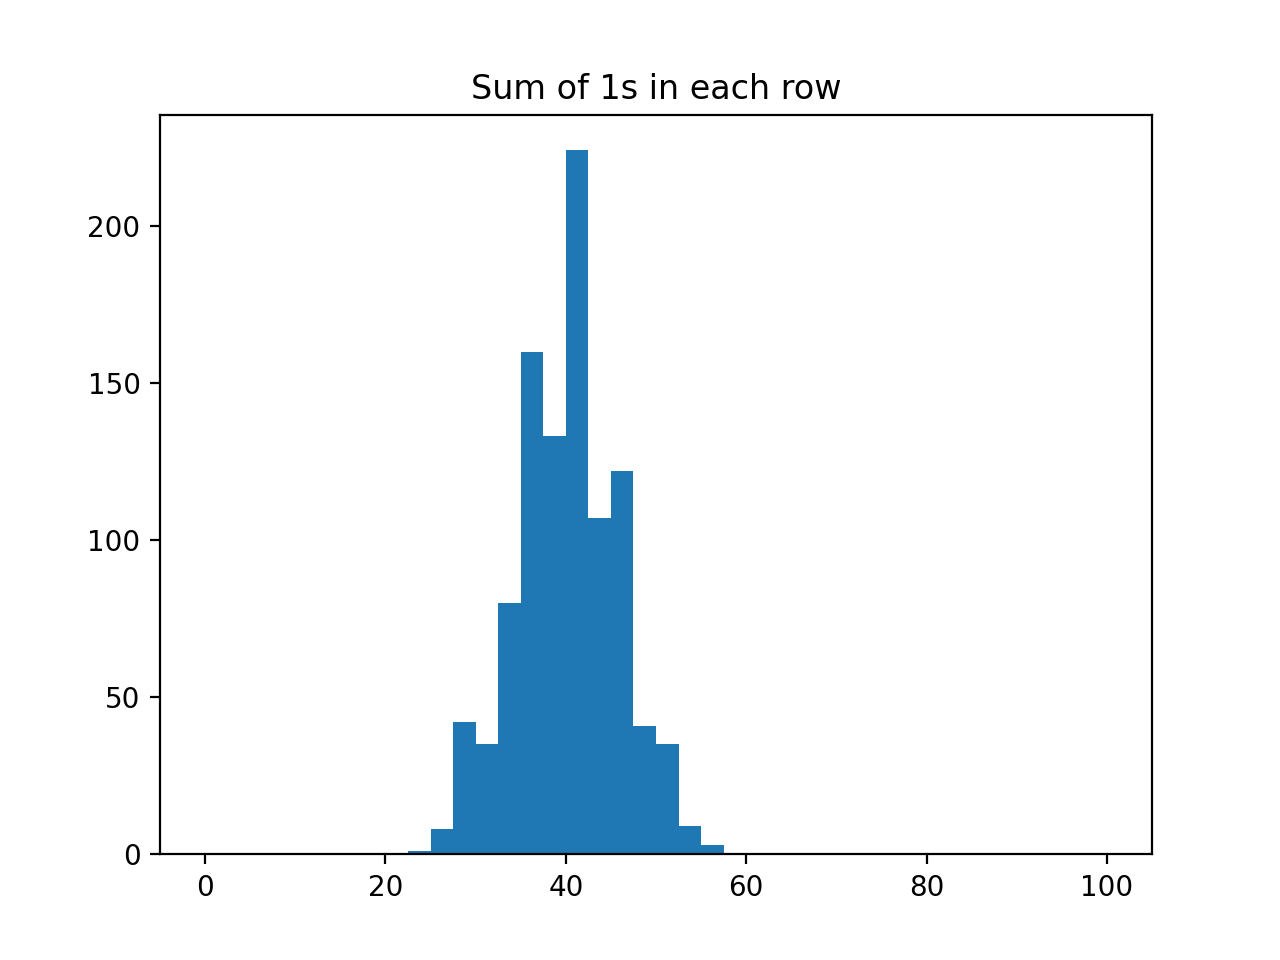

In [6]:
fig, ax = plt.subplots()
ax.hist(a.sum(axis=1), bins=bins*100)
ax.set_title('Sum of 1s in each row');

Let's consider to top 2 rows.

In [7]:
a[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0])

In [8]:
a[1]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

We see that there are 4 entries that overlap.

In [9]:
a[0] * a[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

The cosine similarity is these two values over the magnitude of each vector.

In [10]:
np.dot(a[0], a[1])/(np.sqrt(a[0].sum())*np.sqrt(a[1].sum()))

0.1126872339638022

And this is the same value that we get from our sklearn `cosine_similarity()` function.

In [11]:
cosine_similarity(a[0].reshape(1, -1), a[1].reshape(1, -1)).squeeze()

array(0.11268723)

### Cosine similarity of random binomial

Let's get an all-pairs cosine similarity matrix of these vectors.

In [12]:
cossims = cosine_similarity(a)

This results in a 1000 x 1000 matrix.

In [13]:
cossims.shape

(1000, 1000)

The diagonals are cosine similarity scores with the same vector, so lets set them to NaN. 

In [14]:
di = np.diag_indices(cossims.shape[0])
cossims[di] = np.nan

In [15]:
cossims

array([[       nan, 0.11268723, 0.14580296, ..., 0.20203051, 0.1839418 ,
        0.18523964],
       [0.11268723,        nan, 0.25302404, ..., 0.21912525, 0.14509525,
        0.31311215],
       [0.14580296, 0.25302404,        nan, ..., 0.26805548, 0.2753444 ,
        0.30249507],
       ...,
       [0.20203051, 0.21912525, 0.26805548, ...,        nan, 0.28181074,
        0.29939248],
       [0.1839418 , 0.14509525, 0.2753444 , ..., 0.28181074,        nan,
        0.22715543],
       [0.18523964, 0.31311215, 0.30249507, ..., 0.29939248, 0.22715543,
               nan]])

Notice that the value at [0,  1], the cosine similarity as calculated before between the first two rows, is the same. 

Now, let's look at the distribution of scores.

<IPython.core.display.Javascript object>


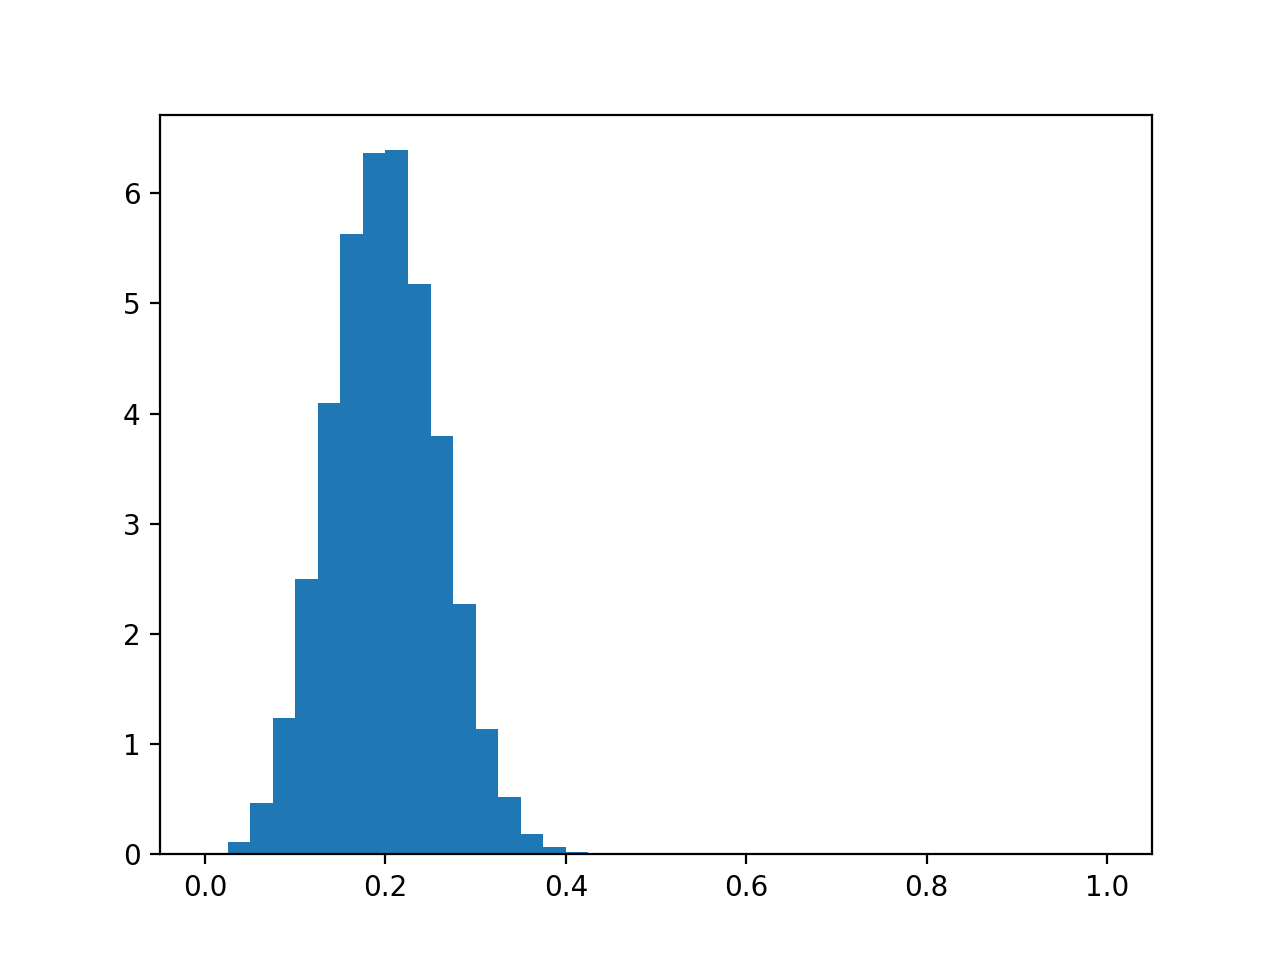

In [16]:
fig, ax = plt.subplots()
ax.hist(cossims.flatten(), bins=bins, density=True);

This shows that it is quite rare for cosine similarities to be over 0.4 with this data.

### Data with 50% overlap

Now, let's contrast the matrix we just made, `a`, with another binomial matrix that has 50% overlap.

In [17]:
np.random.seed(3)

# Get a binomial distribution with the same parameterization as `a`
b = np.random.binomial(n=1, p=p, size=dim)

# Create a mask of 50% of the same dimensions
mask = np.random.randint(2, size=dim)
mask = mask > 0

# Flip off the 1s in b that are not in the mask
b *= mask

# Add the elements in a that are 1 and the mask is False
b += a * np.logical_not(mask)

Confirm that we have a similar distribution of the sum of each row like `a`, above.

<IPython.core.display.Javascript object>


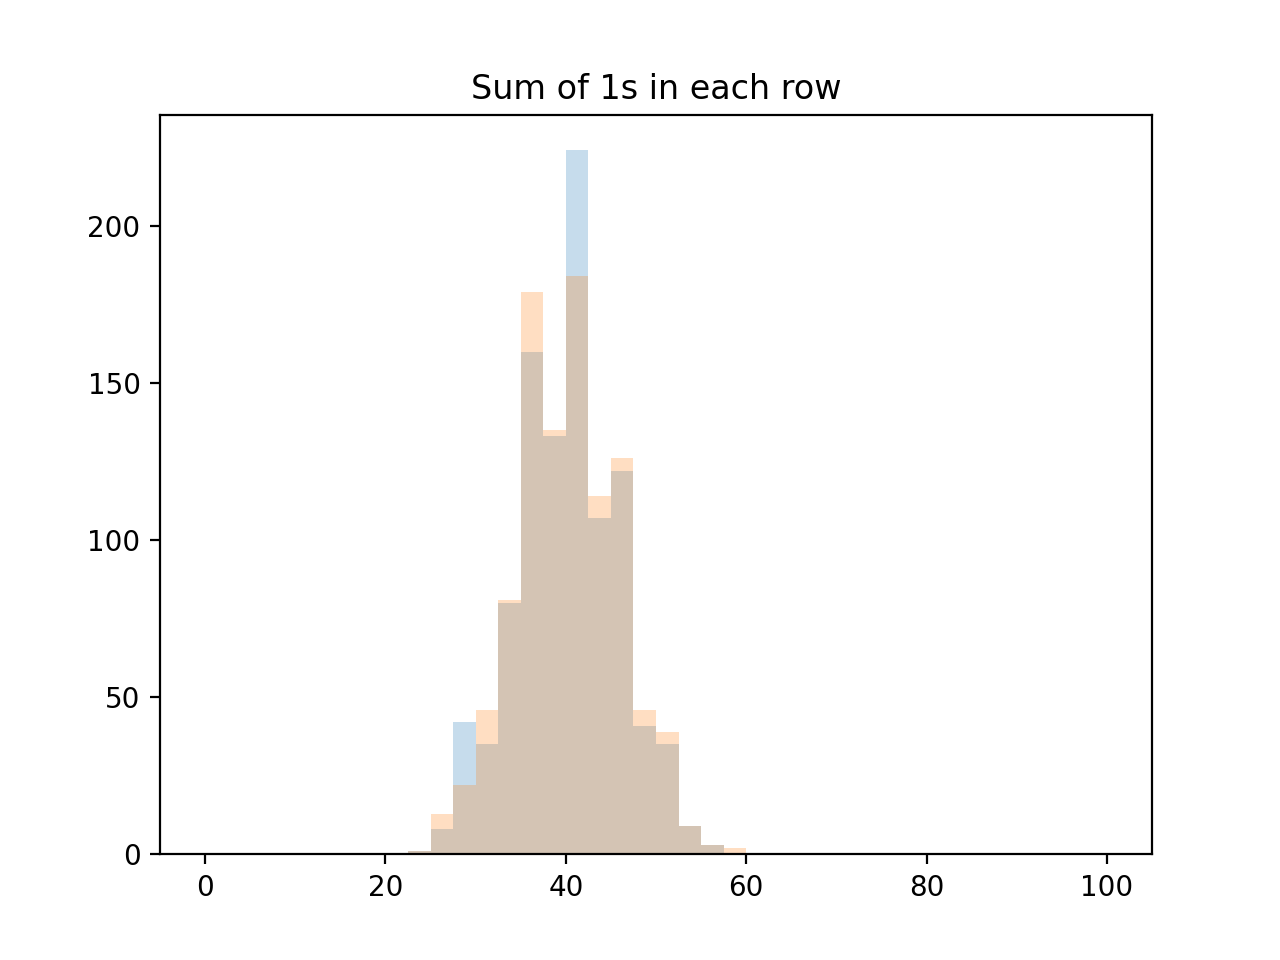

In [18]:
fig, ax = plt.subplots()
alpha = .25
ax.hist(a.sum(axis=1), bins=bins*100, alpha=alpha, label='a')
ax.hist(b.sum(axis=1), bins=bins*100, alpha=alpha, label='b')
ax.set_title('Sum of 1s in each row');

And the cosine similarity of all pairs of `b` should also be quite similar to that in `a`.

<IPython.core.display.Javascript object>


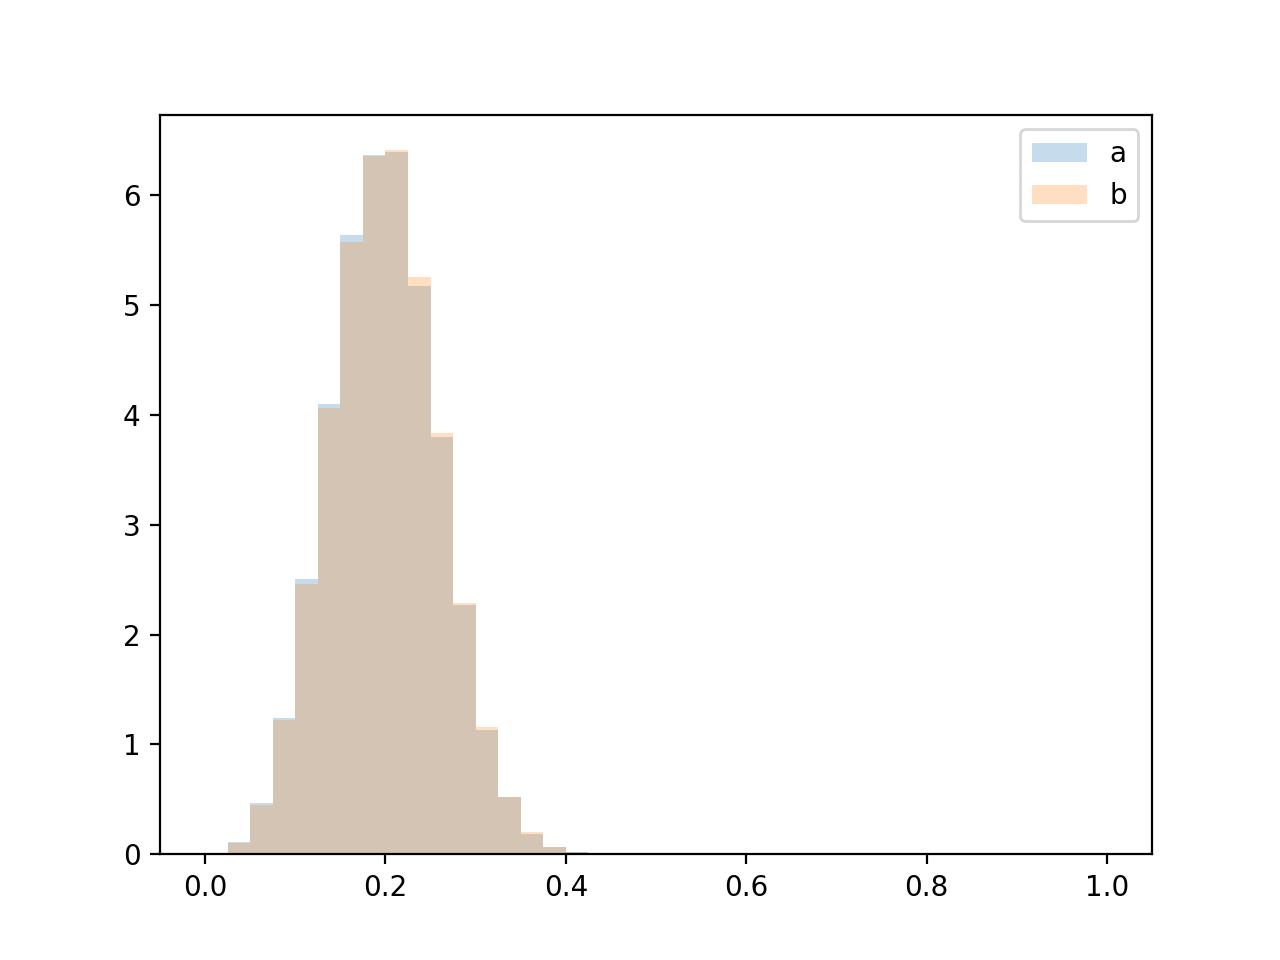

In [19]:
fig, ax = plt.subplots()
alpha = .25
cossims = cosine_similarity(a)
di = np.diag_indices(cossims.shape[0])
cossims[di] = np.nan
ax.hist(cossims.flatten(), bins=bins, density=True, alpha=alpha, label='a');
cossims = cosine_similarity(b)
di = np.diag_indices(cossims.shape[0])
cossims[di] = np.nan
ax.hist(cossims.flatten(), bins=bins, density=True, alpha=alpha, label='b');
ax.legend();

### Evaluate the overlap

Below, instead of calling `cosine_similarity()` with one object for all-pairs similarity, we pass `a` and `b`. This does the right thing and calculates the similarity of all rows in `a` against all rows in `b`. Therefore the cosine similarity of `a[0]` to `b[0]` is at [0, 0], the similarity score of `a[1]` to `b[1]` is at [1, 1], etc. Across a given row, say row 0, we have the cosine similarity of `a[0]` to `b[0]` and to `b[1]` and to `b[2]`, etc. These cosine similarity scores that do not fall on the diagonal are effectively a comparison to a random set since the vectors are randomly generated. It is only those that have correspondence and fall along the diagonal that will we have artificially made to have more overlap. 

In [20]:
cossims = cosine_similarity(a, b)
cossims

array([[0.56148993, 0.17291713, 0.11527808, ..., 0.15877684, 0.25928149,
        0.10910895],
       [0.11072731, 0.68199434, 0.31826403, ..., 0.22961557, 0.2300895 ,
        0.30123204],
       [0.25788071, 0.16471728, 0.56474497, ..., 0.19446112, 0.21170245,
        0.26726124],
       ...,
       [0.17370208, 0.22416327, 0.22416327, ..., 0.71105713, 0.27500955,
        0.28931878],
       [0.12049505, 0.17316974, 0.29686242, ..., 0.29530205, 0.44513191,
        0.18731716],
       [0.13001274, 0.21354071, 0.27760292, ..., 0.29411765, 0.16810224,
        0.58612776]])

Since we have artificially overlapped the corresponding rows in `b` with those in `a`, the diagonals of the
matrix contain our pairwise cosine similarities and the other elements of the row are those that we would otherwise get by chance. As can be seen, the diagonals are greater than the other elements. Let's extract them.

In [21]:
diags = np.diag(cossims).copy()

As shown below, the distribution of cosine similarities when they have about 50% overlap is much higher than what we would get by chance. We will call these our simulated "actual" model output scores.

<IPython.core.display.Javascript object>


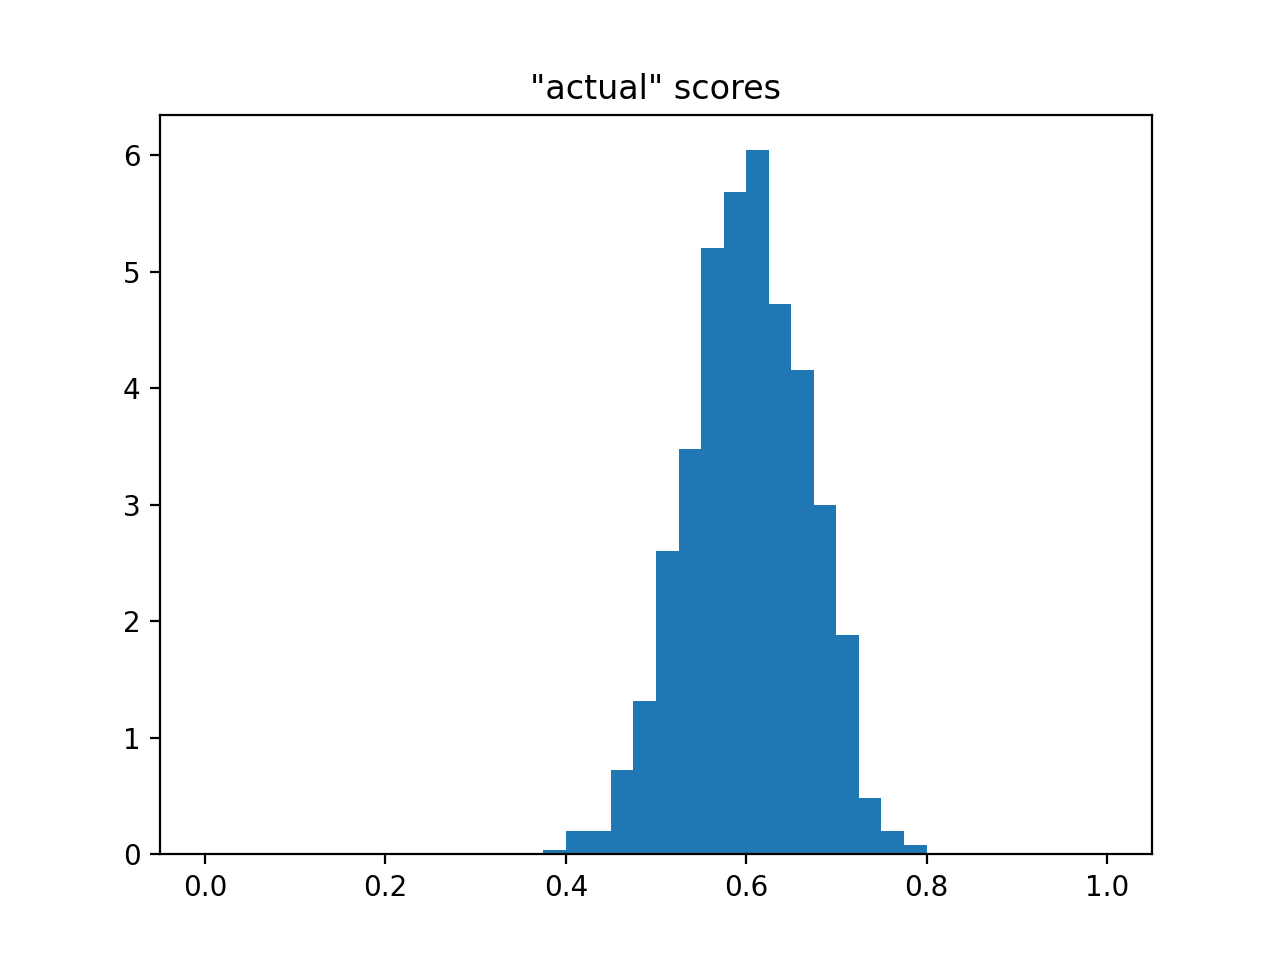

In [22]:
fig, ax = plt.subplots()
ax.hist(diags, bins=bins, density=True)
ax.set_title('"actual" scores');

Now that we have extracted the diagonal values, let's set the diagonals of the matrix to NaN so we can contrast the diagonal value with all other values of a given row.

In [23]:
di = np.diag_indices(cossims.shape[0])
cossims[di] = np.nan

Below, we contrast the coupled "actual" cosine similarity score (red) with those that are random for a given instance. That is, a value of `a` and the cosine similarity of it to all of the other values of `b`. Additionally, we provide the quantile value for this cosine similarity score *within the "actual" distribution*. Modify the slider to change the row. Notice that the shuffled distribution changes, but the actual distribution remains static.

<IPython.core.display.Javascript object>


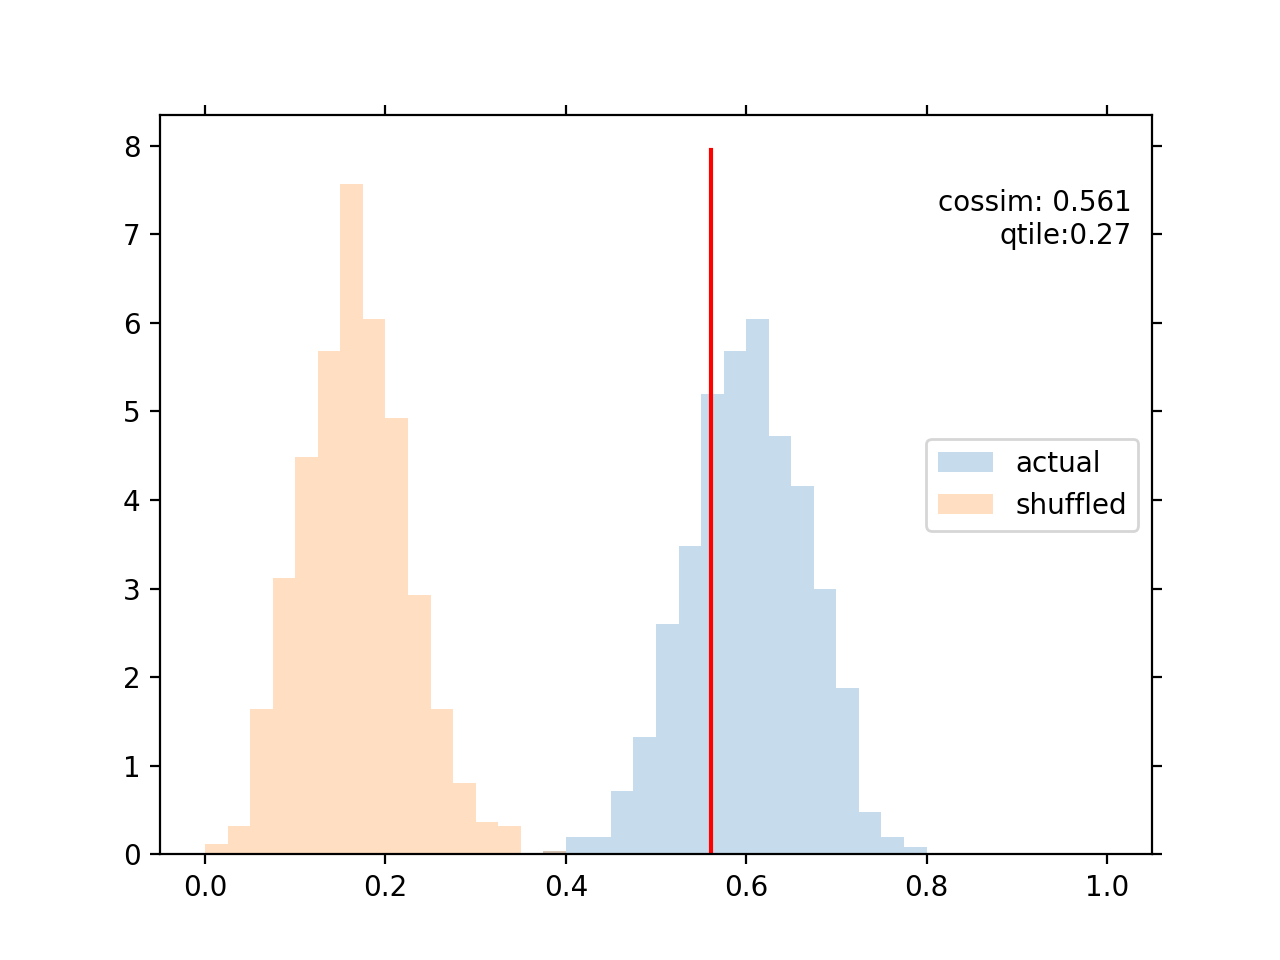

interactive(children=(IntSlider(value=0, description='idx', max=30), Output()), _dom_classes=('widget-interact…

In [24]:
fig, ax = plt.subplots()

@interact(idx=IntSlider(min=0, max=30, step=1, value=0, continuous_update=True))
def draw_fig(idx):
    ax.clear()
    d = diags[idx]
    ax.hist(diags, bins=bins, density=True, alpha=alpha, label='actual');
    ax.hist(cossims[idx], bins=bins, density=True, alpha=alpha, label='shuffled');
    ax.plot([d, d], [0, ax.get_ylim()[-1]], color='red');
    ax.legend(loc='center right');
    sorted_diags = sorted(diags)
    q = bisect(sorted_diags, d)/len(sorted_diags)

    textstr = f'cossim: {d:.3f}\nqtile:{q:.2f}'
    ax.text(0.98, 0.9, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', ha='right');

We see for most samples, the score is well outside the random distribution. In these cases, the confidence should approach 1.

# Towards confidence

Given the distributions of random (null hypothesis) vs. actual, we apply logistic regression to label the probability of an observed value being in the actual dataset.

We define the **confidence** of a score belonging to one group or another as $2 \cdot \max(P(x=0), P(x=1)) - 1$ where $P(x=0)$ is the probability of the NULL hypothesis and $P(x=1)$ is the probability of the actual distribution. As seen below, at locations near the "crossover" where the histograms are nearly equal, the confidence approaches 0.

In [25]:
@interact(idx=IntSlider(min=0, max=30, step=1, value=0, continuous_update=False))
def draw_fig(idx):
    d = diags[idx]
    X1 = diags
    X0 = np.concatenate([cossims[idx, :idx], cossims[idx, idx+1:]])
    X = np.concatenate([X0, X1]).reshape(-1, 1)
    y = np.zeros(X.shape[0])
    y[-X1.shape[0]:] = 1
    clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=0, class_weight='balanced').fit(X, y)
    x = np.linspace(0, 1, 101)
    log_prob = clf.predict_proba(x.reshape(-1, 1))
#     conf = 2 * np.max(log_prob, axis=1) - 1
    conf = log_prob[:, 1]

    fig, ax = plt.subplots()
    ax.hist(diags, bins=bins, density=True, alpha=alpha, label='actual');
    ax.hist(cossims[idx], bins=bins, density=True, alpha=alpha, label='shuffled');
    ax.plot([d, d], [0, ax.get_ylim()[-1]], color='red');
    
    ax_conf = ax.twinx()
    ax_conf.plot(x, conf, label='confidence', color='black')
    ax_conf.plot(x, log_prob[:,1], label='log prob')
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_conf.get_legend_handles_labels()
    ax_conf.legend(lines + lines2, labels + labels2, loc='center right')
    
    c = (2*np.max(clf.predict_proba(d.reshape(-1, 1)).squeeze()))-1
    sorted_diags = sorted(X1)
    q = bisect(sorted_diags, d)/len(sorted_diags)

    textstr = f'cossim: {d:.3f}\nqtile:{q:.2f}\nconfidence: {c:.3f}'
    ax.text(0.98, 0.9, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', ha='right');

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=30), Output()), _dom_…

## Better exploration environment

We can modify some parameters to better explore distributions:

  * `idx`: Particular row index.
  * `a_prob`: Binomial probability of the `a` values.
  * `b_prob`: Binomial probability of the `b` values. By having different probabilities of `a` and `b`, this can mimic cases where one class has more non-zero values than the other.
  * `b_overlap_recip`: We take this number to be the reciprocal of the fraction used for overlap. (Chosen this way as an integer for the way we calculate the mask.) For example, 2 yields a reciprocal fraction of 1/2 that provides 50% overlap. 10 yields a reciprocal of 1/10 overlap.
  * `n_rows`: Number of data points.
  * `n_cols`: Vector length of each row.

In [26]:
idx_slider=IntSlider(min=0, max=30, step=1, value=0, continuous_update=False)
a_prob_slider=FloatSlider(min=0.05, max=.95, step=.05, value=.2, continuous_update=False)
b_prob_slider=FloatSlider(min=0.05, max=.95, step=.05, value=.2, continuous_update=False)
b_overlap_recip_slider=IntSlider(min=1, max=20, step=1, value=2, continuous_update=False)
n_rows_slider=IntSlider(min=100, max=10000, step=100, value=1000, continuous_update=False)
n_cols_slider=IntSlider(min=10, max=200, step=10, value=100, continuous_update=False)

@interact(idx=idx_slider, a_prob=a_prob_slider, b_prob=b_prob_slider,
         b_overlap_recip=b_overlap_recip_slider, n_rows=n_rows_slider, n_cols=n_cols_slider)
def simulation(idx=0, a_prob=.2, b_prob=.2, b_overlap_recip=2, n_rows=1000, n_cols=100):
    dim = (n_rows, n_cols)
    np.random.seed(2)
    a = np.random.binomial(n=1, p=a_prob, size=dim)
    np.random.seed(3)
    b = np.random.binomial(n=1, p=b_prob, size=dim)

    # Create a mask of 50% of the same dimensions
    mask = np.random.randint(b_overlap_recip, size=dim)
    mask = mask > 0
    # Flip off the 1s in b that are not in the mask
    b *= mask
    # Add the elements in a that are 1 and the mask is False
    b += a * np.logical_not(mask)
    cossims = cosine_similarity(a, b)
    diags = np.diag(cossims).copy()
    di = np.diag_indices(cossims.shape[0])
    cossims[di] = np.nan
    
    fig, ax = plt.subplots()
    d = diags[idx]
    X1 = diags
    X0 = np.concatenate([cossims[idx, :idx], cossims[idx, idx+1:]])
    X = np.concatenate([X0, X1]).reshape(-1, 1)
    y = np.zeros(X.shape[0])
    y[-X1.shape[0]:] = 1
    clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=0, class_weight='balanced').fit(X, y)
    x = np.linspace(0, 1, 101)
    log_prob = clf.predict_proba(x.reshape(-1, 1))    
#     conf = 2 * np.max(log_prob, axis=1) - 1
    conf = log_prob[:, 1]

    ax.hist(diags, bins=bins, density=True, alpha=alpha, label='actual');
    ax.hist(cossims[idx], bins=bins, density=True, alpha=alpha, label='shuffled');
    ax.plot([d, d], [0, ax.get_ylim()[-1]], color='red');
    
    ax_conf = ax.twinx()
    ax_conf.plot(x, conf, label='confidence', color='black')
    ax_conf.plot(x, log_prob[:,1], label='log prob')
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_conf.get_legend_handles_labels()
    ax_conf.legend(lines + lines2, labels + labels2, loc='center right')
    c = (2*np.max(clf.predict_proba(d.reshape(-1, 1)).squeeze()))-1
    sorted_diags = sorted(X1)
    q = bisect(sorted_diags, d)/len(sorted_diags)

    textstr = f'cossim: {d:.3f}\nqtile:{q:.2f}\nconfidence: {c:.3f}'
    ax.text(0.98, 0.9, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', ha='right');

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=30), FloatSlider(valu…

### Specific cases to evaluate

#### More data and features create smoother distributions.

Notice how modulations of `n_rows`, and `n_cols` modifies the granularity of the distributions. In general, `n_cols` has a greater impact on this than `n_rows`.

#### Decreasing the coupling increases the overlap between distributions.

By increasing `b_overlap_recip`, this is the reciprocal of the coupling rate, so larger values result in less coupling. For example, 10 means there is 1/10th of the 1s in `a` that correspond to activations in `b`, whereas 2 means 1/2 of the 1s in `a` will be found in `b`.

##### More shuffled than actual

As a specific example, consider `idx=7`, `a_prob=0.1`, `b_prob=0.4`, `b_overlap_recip=10`, `n_rows=1000`, `n_cols=200`. In this case, a cosine similarity of 0.112 is more likely to be in the shuffled distribution than the actual. It has a confidence of 0.425, which is our confidence of it being in the shuffled set as compared to the actual set.

<a name="caveats"></a>
# Caveats and Concerns

The approach presented here generic, but not necessarily widely applicable. It works for similarity measures such as cosine similarity that are relatively quick to compute with under 5000 or so shuffled records that can be cached. If calculating such a feature vector is computationally prohibitive, or storing the shuffled records is problematic for memory, or more records are necessary, then this approach may not work.

Additionally, this approach works well for distributions that segment well using logistic regression. If logistic regression cannot easily differentiate random data from actual data, then the above method will not work. Instead, one might have to train some other type of model or use other rules for ascertaining confidence of actual vs. shuffled.

# Conclusion

The proposal presented provides a confidence score that is described as the probability of being in either a randomly shuffled class or in the actual distribution of scores. More specifically, we define the **confidence** of a score belonging to one group or another as $2 \cdot \max(P(x=0), P(x=1)) - 1$ where $P(x=0)$ is the probability of the NULL hypothesis and $P(x=1)$ is the probability of the actual distribution. The demonstration provided here uses cosine similarity of two vectors, a common similarity measure. It is straightforward for a model to cache the distribution of actual scores to maintain its "actual" distribution and to provide a quantile score for a given cosine similarity value. As well, it is simple for the model to store 1000+ random vectors, which are representative of one of the classes, to dynamically calculate a random/shuffled distribution of scores by which to compare.